# MLP 모델 설계
---
> 1. Import Moudles
> 2. CUDA OR CPU Check
> 3. MNIST Data Download (Train/Test)
> 4. Data Check(1) - train, test
> 5. Data Check(2) - visualization
> 6. MLP 설계
> 7. Optimizer, Objective Function 설정
> 8. 모델 성능 확인 함수
> 9. 검증 성능 확인 함수
> 10. Train, Test Loss 및 Accuracy 확인

# 1.Impot Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

# 2.CUDA OR CPU Check

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS =30

print(f"Pytorch Version : {torch.__version__,}\nDevice : {DEVICE}")
print(f"BATCH SIZE : {BATCH_SIZE}\nEPOCHS:{EPOCHS}")

Pytorch Version : ('1.10.1',)
Device : cuda
BATCH SIZE : 32
EPOCHS:30


# 3.MNIST Data Download

In [4]:
train_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "./data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

# 4.Data Check(1) - Train/Test

In [5]:
for (X_train, y_train) in train_loader:
    print(f"X_train: {X_train.size()} \ntype: {X_train.type}\n")
    print(f"y_train: {y_train.size()} \ntype: {y_train.type}")
    break

X_train: torch.Size([32, 1, 28, 28]) 
type: <built-in method type of Tensor object at 0x00000223894D0F40>

y_train: torch.Size([32]) 
type: <built-in method type of Tensor object at 0x00000223995B7D60>


# 5.Data Check(2) - Visualization

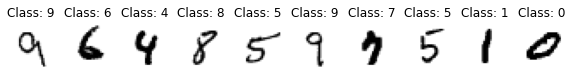

In [6]:
pltSize=1
plt.figure(figsize=(10*pltSize, pltSize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis("off")
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title(f"Class: {str(y_train[i].item())}")

# 6.MLP 설계 - <span style="color:magenta">Dropout 추가</span> (1)
---
```python
F.dropout(x, training, p)
```
- `x` : forward 전달 상태
- `training` : 학습 상태와 검증 상태에 따라 다르게 적용
    - 학습 상태 - 랜덤으로 노드를 선택하여 가중값이 업데이트 되지 않도록 조정 
    - 검증 상태(평가) - 모든 노들를 이용하여 Output을 계산
    > 따라서 두 상태는 다르게 적용되어야 함
    
    `model.train()`->`self.training=True`  
    `model.eval()` -> `self.training=False`

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = .5
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# 6.MLP 설계(2) - <span style="color:magenta">Dropout, ReLu</span>
---
```python
F.dropout(x, training, p)
F.relu(x)
```

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = .5
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# 6.MLP 설계(3) - <span style="color:magenta">Dropout, ReLU, Batch Normalization</span>
---
- Batch Normalization은 1D, 2D, 3D 등 다양한 차원에 따라 적용되는 함수명이 다름
- MLP 내 각 Layer에서 데이터는 1D 크기의 벡터값을 계산 --> `nn.BatchNorm1d()`
- Batch Normalization은 활성 함수 전에 사용하기도, 후에 사용하기도 하는데 이는 연구자마다 상이함
- 밑의 코드는 활성함수 전에 추가

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = .5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# 7.Optimizer, Objective Function 설정

In [8]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=.5)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


# 8.모델 성능 확인 함수

In [9]:
def train(model, train_loader, optimizer, log_interval):
    # 모델 학습 상태 저장
    model.train()
    
    # 한 배치에 포함된 이미지와 라벨 단위로 학습 진행
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        # Gradient 초기화
        optimizer.zero_grad()
        
        # 모델을 통해 input에 대한 output
        output = model(image)
        
        # output과 label의 손실 함수
        loss = criterion(output, label)
        
        # Loss 값 계산의 결과를 바탕으로 Back Propagation을 통해 계산된
        # Gradient 값을 각 파라미터에 할당
        loss.backward()
        
        # 각 파라미터에 할당된 Gradient 값으로 파라미터 업데이트
        optimizer.step()
        
        # if batch_idx % log_interval == 0:
        #     print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx*len(image),
        #                                                                          len(train_loader.dataset), 100.*batch_idx/len(train_loader),
        #                                                                          loss.item()))

# 9.검증 성능 확인 함수

In [10]:
def evaluate(model, test_loader):
    # 현재 모델을 평가 상태로 지정
    model.eval()
    
    # test_loss 초기화
    test_loss=0
    
    # MLP 모델의 올바른 분류의 경우를 세는 correct 초기화
    correct = 0
    
    # Gradient를 통한 파라미터 업데이트를 방지하기 위해 Gradient 흐름 억제
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            # loss 값 업데이트
            test_loss += criterion(output, label).item()
            
            # output의 가장 큰 값인 위치에 대해 이에 대응하는 클래스로 예측
            prediction = output.max(1, keepdim=True)[1]
            
            # 일치하면 맞았다고 셈 
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    # test_loader에 존재하는 미니배치의 갯수만큼 나누어 평균 loss 계산        
    test_loss /= len(test_loader.dataset)
    
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 10.Train, Test Loss 및 Accuracy 확인

In [11]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".
    format(Epoch, test_loss, test_accuracy))


[EPOCH: 1], 	Test Loss: 0.0048, 	Test Accuracy: 95.12 % 


[EPOCH: 2], 	Test Loss: 0.0035, 	Test Accuracy: 96.55 % 


[EPOCH: 3], 	Test Loss: 0.0031, 	Test Accuracy: 97.02 % 


[EPOCH: 4], 	Test Loss: 0.0027, 	Test Accuracy: 97.35 % 


[EPOCH: 5], 	Test Loss: 0.0025, 	Test Accuracy: 97.63 % 


[EPOCH: 6], 	Test Loss: 0.0022, 	Test Accuracy: 97.80 % 


[EPOCH: 7], 	Test Loss: 0.0023, 	Test Accuracy: 97.82 % 


[EPOCH: 8], 	Test Loss: 0.0021, 	Test Accuracy: 97.90 % 


[EPOCH: 9], 	Test Loss: 0.0020, 	Test Accuracy: 98.08 % 


[EPOCH: 10], 	Test Loss: 0.0020, 	Test Accuracy: 98.03 % 


[EPOCH: 11], 	Test Loss: 0.0018, 	Test Accuracy: 98.12 % 


[EPOCH: 12], 	Test Loss: 0.0019, 	Test Accuracy: 98.08 % 


[EPOCH: 13], 	Test Loss: 0.0019, 	Test Accuracy: 98.17 % 


[EPOCH: 14], 	Test Loss: 0.0018, 	Test Accuracy: 98.14 % 


[EPOCH: 15], 	Test Loss: 0.0018, 	Test Accuracy: 98.31 % 


[EPOCH: 16], 	Test Loss: 0.0017, 	Test Accuracy: 98.17 % 


[EPOCH: 17], 	Test Loss: 0.0017, 	Test Accuracy: